In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [60]:
def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    
    def _change_one_hot_label(X):
        T = np.zeros((X.size, 10))
        for idx, row in enumerate(T):
            row[X[idx]] = 1
            
        return T
    
    with open('mnist.pkl', 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])
        
    if not flatten:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)
        
    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])

In [61]:
def img_show(img):
    plt.imshow(img, cmap='gray_r')
    plt.show()

In [62]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True,
                                                 flatten=True,
                                                 one_hot_label=False)

In [63]:
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

7


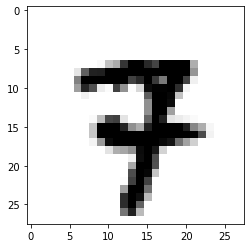

In [64]:
ind = np.random.randint(x_train.shape[0])
img = x_train[ind]
label = t_train[ind]
print(label)

img = img.reshape(28, 28)
img_show(img)

In [71]:
def init_network():
    with open("sample_weight.pkl", "rb") as f:
        network = pickle.load(f)
        
    return network
        
def sigmoid(x):
    return 1/(1 + np.exp(-1*x))

def softmax(x):
    sum_exp_x = np.sum(np.exp(x), axis=-1).reshape(-1, 1)
    return np.exp(x) / sum_exp_x
    
def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    
    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    
    a3 = np.dot(z2, W3) + b3
    z3 = softmax(a3)
    
    y = z3 # output
    
    return y

In [72]:
model = init_network()
accuracy_cnt = 0
for i in range(len(x_test)):
    y = predict(model, x_test[i])
    p = np.argmax(y)
    if p == t_test[i]:
        accuracy_cnt += 1
        
print("Accuracy : ", str(float(accuracy_cnt)/len(x_test)))

Accuracy :  0.9352


In [73]:
model['W1'].shape, model['W2'].shape, model['W3'].shape

((784, 50), (50, 100), (100, 10))

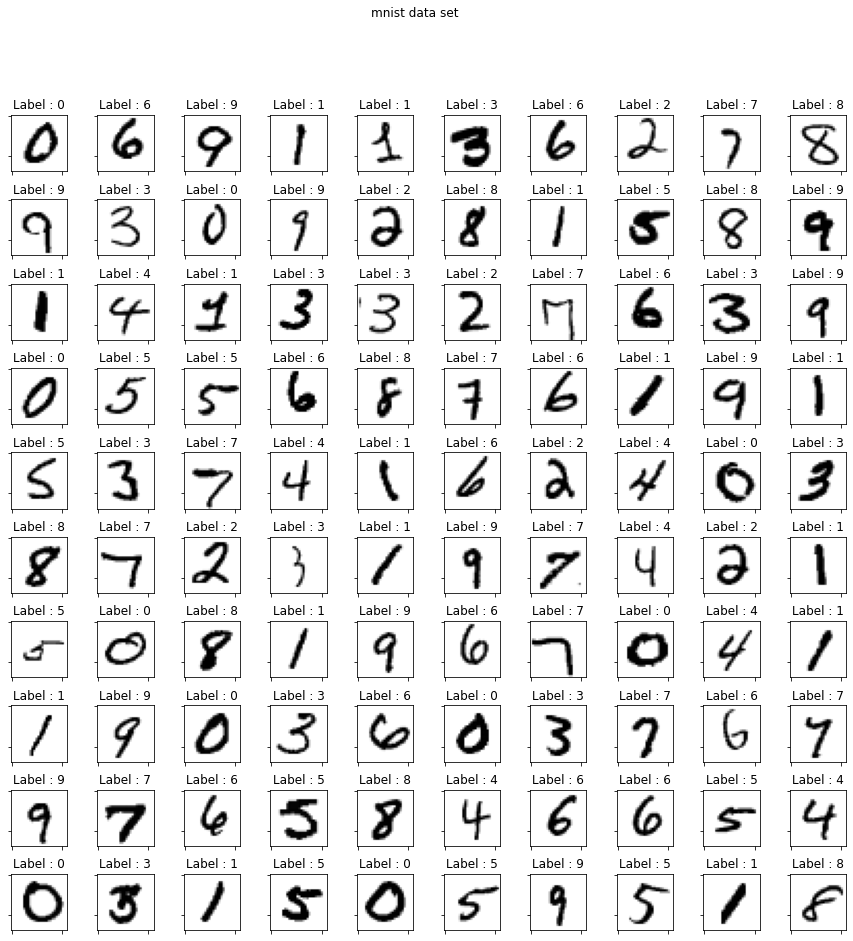

In [68]:
import matplotlib as mpl

def displayData(X, Y):
    fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(15, 15))
    fig.suptitle("mnist data set")
    for i in range(10):
        for j in range(10):
            ind = np.random.randint(X.shape[0])
            tmp = X[ind, :].reshape(28, 28)
            ax[i, j].set_title("Label : {}".format(Y[ind]))
            ax[i, j].imshow(tmp, cmap='gray_r')
            plt.setp(ax[i, j].get_xticklabels(), visible=False)
            plt.setp(ax[i, j].get_yticklabels(), visible=False)
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
displayData(x_train, t_train)

# row 1줄씩 읽어서 accuracy 구하기

In [74]:
%%time

#model = init_network()
accuracy_cnt = 0
for i in range(len(x_train)):
    y = predict(model, x_train[i])
    p = np.argmax(y)
    if p == t_train[i]:
        accuracy_cnt += 1
        
print("Accuracy : ", str(float(accuracy_cnt)/len(x_train)))

Accuracy :  0.9357666666666666
CPU times: user 3.54 s, sys: 250 ms, total: 3.79 s
Wall time: 1.98 s


# batch size만큼 rows 잘라서 accuracy 구하기

In [80]:
def softmax(x):
    sum_exp_x = np.sum(np.exp(x), axis=-1).reshape(-1, 1)
    return np.exp(x) / sum_exp_x

# def softmax(x):
#     return np.exp(x)/np.sum(np.exp(x))
    
def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    
    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    
    a3 = np.dot(z2, W3) + b3
    z3 = softmax(a3)
    
    y = z3 # output
    
    return y

In [81]:
%%time
network = init_network()
accuracy_cnt = 0
batch_size = 100

for i in range(0, len(x_train), batch_size):
    x_batch = x_train[i:i+batch_size]
    t_batch = predict(network, x_batch) # 100x10 (batchsize=100행, 숫자 0~9 각각의 확률 컬럼 10열)
    p = np.argmax(t_batch, axis=1) # 각각의 row에 대해서 숫자 0~9일 확률 중 최대인 값의 인덱스를 반환
                                    # 인덱스 값 = 예측 숫자값 이므로 argmax 인덱스값 자체가 예측 label이 됨.
    
#     if i == 0:
#         print(t_batch, end='\n')
#         print(t_batch.shape, end='\n')
#         print(p, end='\n')
        
    accuracy_cnt += np.sum(p==t_train[i:i+batch_size]) # 맞힌 갯수만큼 더해준다
print("accuracy : "+str(float(accuracy_cnt)/len(x_train))) # 맞힌 총 갯수를 트레인데이터 사이즈로 나눠준다

accuracy : 0.9357666666666666
CPU times: user 316 ms, sys: 17.8 ms, total: 334 ms
Wall time: 190 ms
